# Recurrent neural networks


### Time Interval Categorization Task

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-bright')

import torch
import torch.nn.functional as F
from torch import nn

from scipy.optimize import root
from sklearn.decomposition import PCA

import tasks
import models
import model_parameters
import helpers

device = torch.device("cpu")

## Analysis

In [ ]:
def trials_analysis(model, data, ends, vanilla_euler = False):
  with torch.no_grad():
    scores = torch.zeros(targets.shape)
    hidden = torch.zeros(batch_size, len(tv), hidden_size)
    for b in range(batch_size):
      if vanilla_euler:
        scores1, hidden1 = model.foward_euler(data, ends, b, alpha)
      else:
        scores1, hidden1 = model(data, ends, b)
      hidden[b, :, :] = hidden1
      scores1[0, :int(starts[0, b] - 1), :] *= 0
      scores[b, :int(ends[0, b]), :] = scores1

  return scores, hidden

plot_T2 = time2indx(0.2)

delay_arange = np.round(np.arange(0.2, 1.1, 0.1), 2)
t_responses = [0.6, 0.9, 1.2]
t_go_cue_down = 2. # 0.3 #
t_ext = 0.5

### Changed delay time

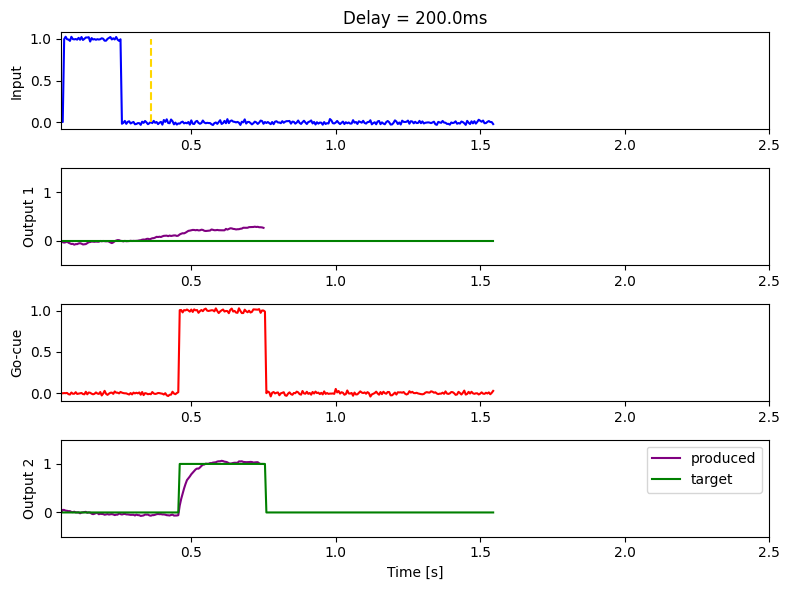

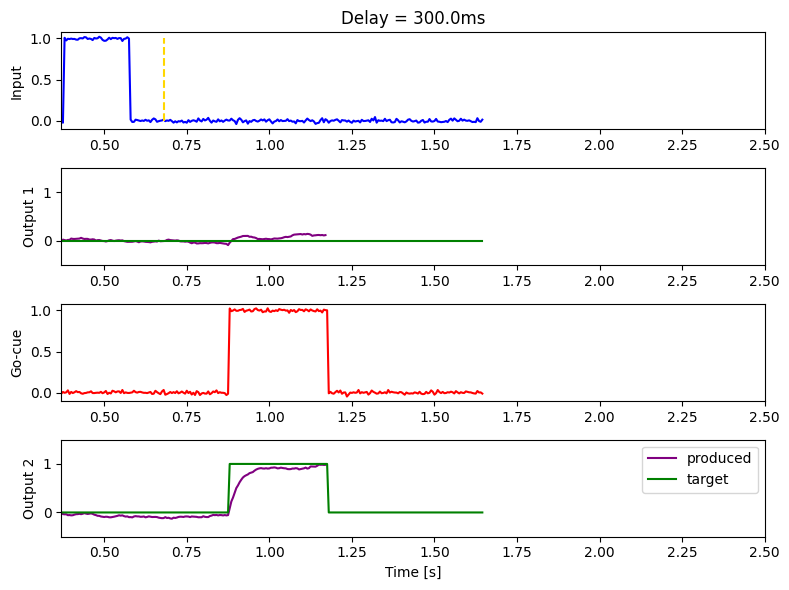

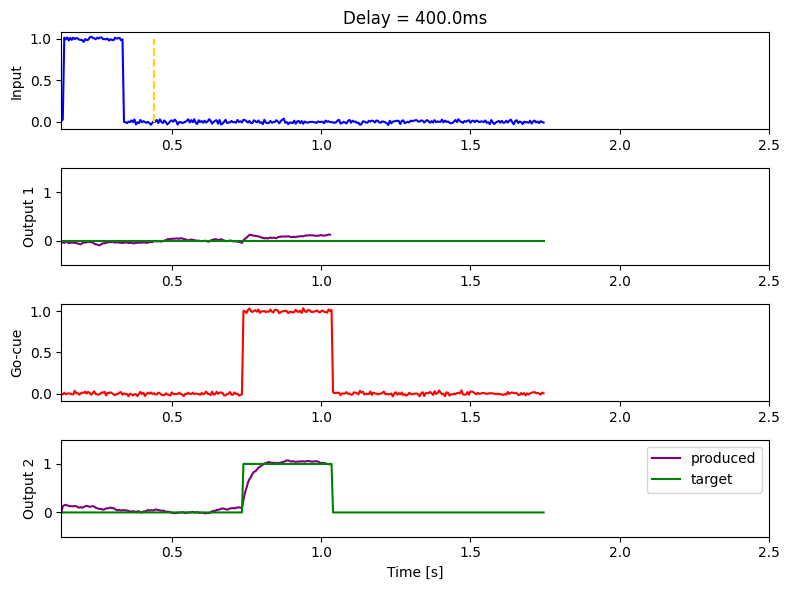

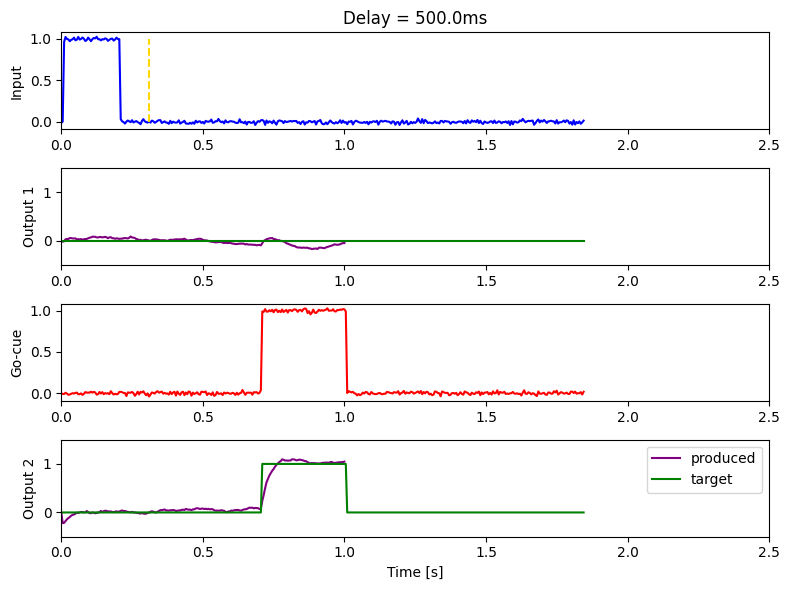

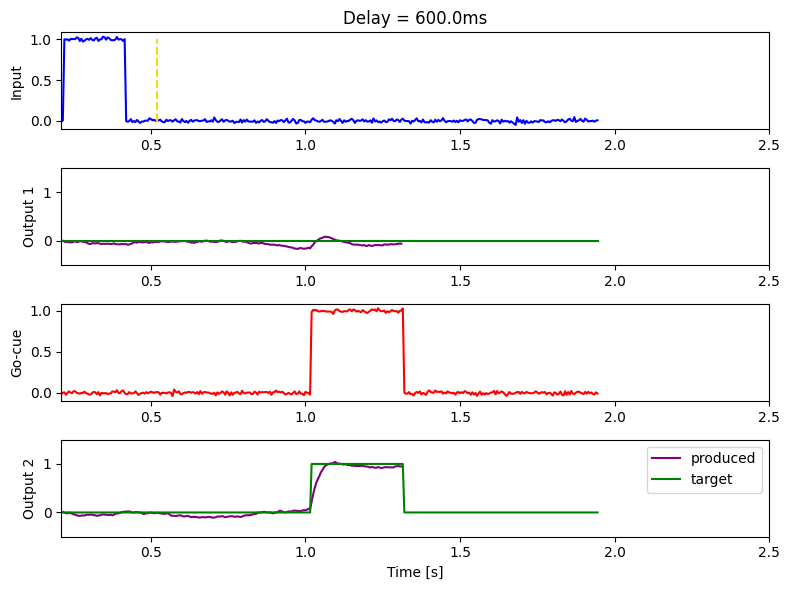

KeyboardInterrupt: 

In [ ]:
for t_max_delay in delay_arange:
  t_final = t_max_start + t_max_stim1 + t_max_delay + t_response
  tv, trials, correct_responses, go_cue, trial_times, objetives = create_trials()

  inputs, labels, starts, ends, Ts, obj = get_random_trials()
  T2s = Ts[1, :]
  T3s = Ts[2, :]
  data, targets = get_data(inputs, labels)

  scores, _ = trials_analysis(model, data, ends)

  title = "Delay = " + str(t_max_delay * 1000) + "ms"
  for n in range(batch_size):
    if T2s[n] == plot_T2:
      break

  start = (starts[0,n] - 2) * step
  plot_trial(n, title = title, xlims = [start, 2.5])

### Change response time

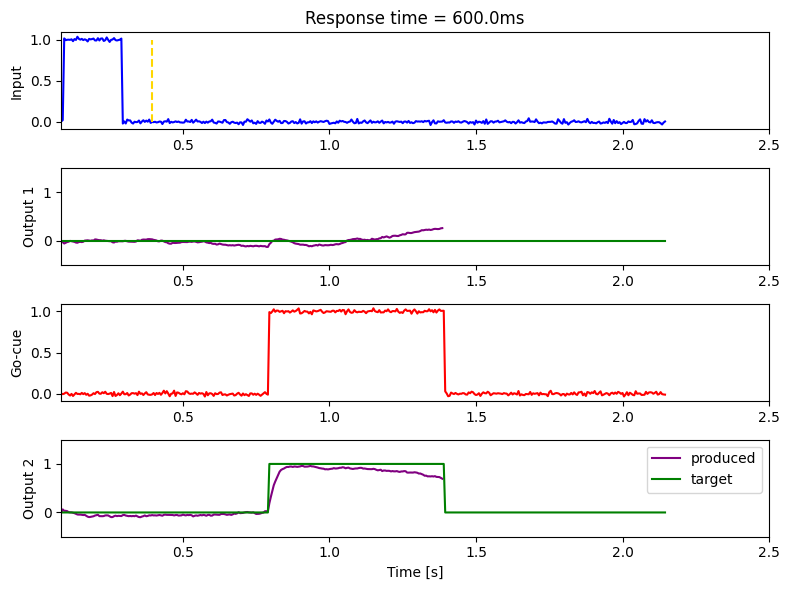

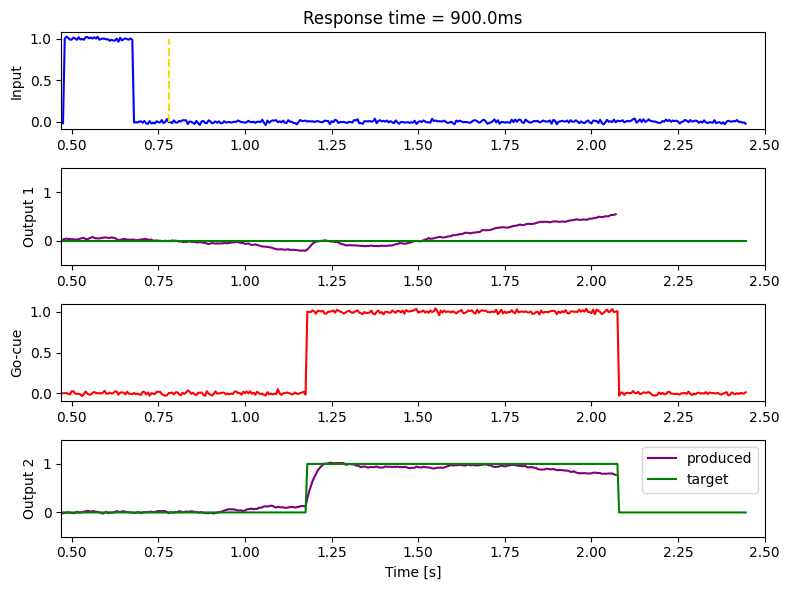

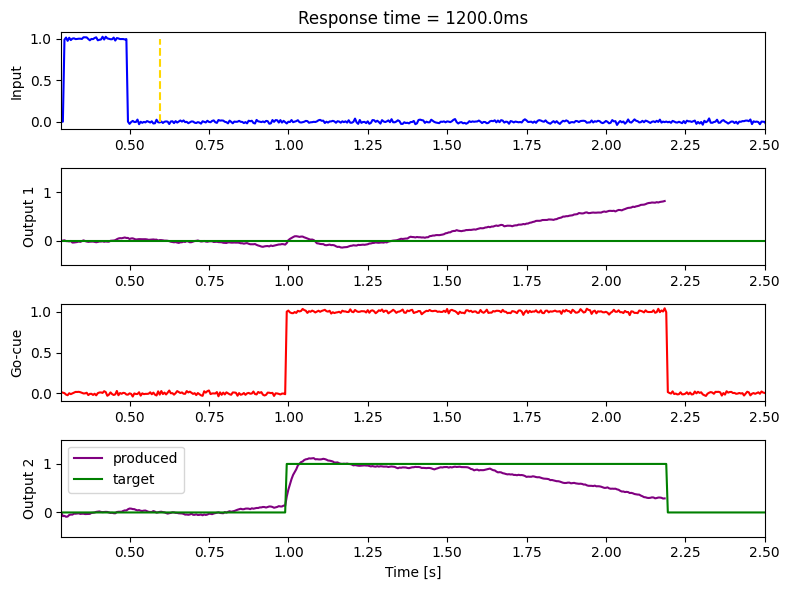

In [ ]:
for t_response in t_responses:
  t_final = t_max_start + t_max_stim1 + t_max_delay + t_response
  tv, trials, correct_responses, go_cue, trial_times, objetives = create_trials()

  inputs, labels, starts, ends, Ts, obj = get_random_trials()
  T2s = Ts[1, :]
  T3s = Ts[2, :]
  data, targets = get_data(inputs, labels)

  scores, _ = trials_analysis(model, data, ends)

  title = "Response time = " + str(t_response * 1000) + "ms"
  for n in range(batch_size):
    if T2s[n] == plot_T2:
      break

  start = (starts[0,n] - 2) * step
  plot_trial(n, title = title, xlims = [start, 2.5])

### State Similarity

In [ ]:
t_final = t_max_start + t_max_stim1 + t_max_delay + t_response + t_go_cue_down
tv, trials, correct_responses, go_cue, trial_times, objetives = create_trials()
inputs, labels, starts, ends, Ts, obj = get_random_trials()
T2s = Ts[1, :]
T3s = Ts[2, :]
data, targets = get_data(inputs, labels)

for n in range(batch_size):
  if T2s[n] == plot_T2:
    break

ends[0, n] += time2indx(t_go_cue_down)
scores, hidden = trials_analysis(model, data, ends, vanilla_euler=False)

#Cosine similarity

len_trial = ends[0,n]
CS = np.zeros((len_trial, len_trial))
for t1 in range(len_trial):
  for t2 in range(t1, len_trial):
    a = hidden[n, t1, :]
    b = hidden[n, t2, :]
    CS[t1, t2] = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    CS[t2, t1] = CS[t1, t2]

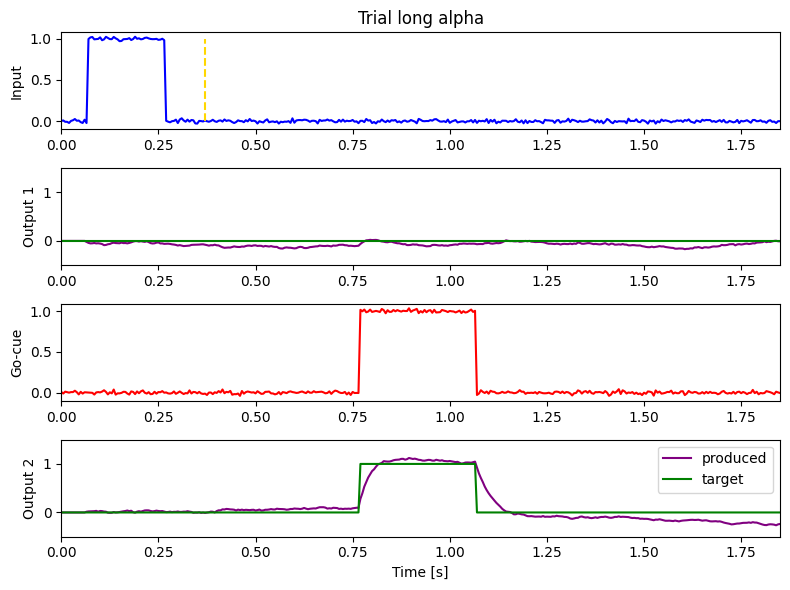

In [ ]:
title = "Trial long alpha"
plot_trial(n, title = title)

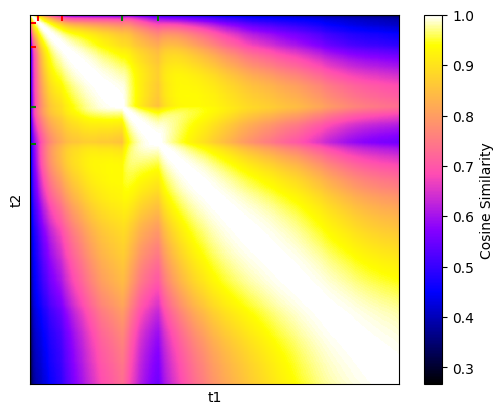

In [ ]:
len_line = 10

plt.imshow(CS[1:,1:], cmap="gnuplot2")
plt.vlines(Ts[0,n] - 1, 0, len_line, linestyle="--", color="red")
plt.hlines(Ts[0,n] - 1, 0, len_line, linestyle="--", color="red")
plt.vlines(Ts[0,n] + Ts[1,n] - 1, 0, len_line, linestyle="--", color="red")
plt.hlines(Ts[0,n]  + Ts[1,n] - 1, 0, len_line, linestyle="--", color="red")
plt.vlines(Ts[4,n] - 1, 0, len_line, linestyle="--", color="green")
plt.hlines(Ts[4,n] - 1, 0, len_line, linestyle="--", color="green")
plt.vlines(Ts[3,n] - 1, 0, len_line, linestyle="--", color="green")
plt.hlines(Ts[3,n] - 1, 0, len_line, linestyle="--", color="green")

plt.xticks([])
plt.yticks([])
plt.xlabel("t1")
plt.ylabel("t2")
plt.colorbar(label="Cosine Similarity")
plt.show()

### Two trials in a row

In [ ]:
inputs, labels, starts, ends, Ts, obj = get_random_trials()
T2s = Ts[1, :]
T3s = Ts[2, :]
data, targets = get_data(inputs, labels)

for n in range(batch_size):
  if T2s[n] == plot_T2:
    break

end2 = torch.tensor([ends[0, n] + ends[0, n + 1]]).reshape(1, 1)
data2 = torch.cat((data[n, :ends[0, n], :],
                  data[n + 1, :ends[0, n + 1], :]), dim = 0)
data2 = data2.unsqueeze(0)
scores, hidden = model(data2, end2, 0)

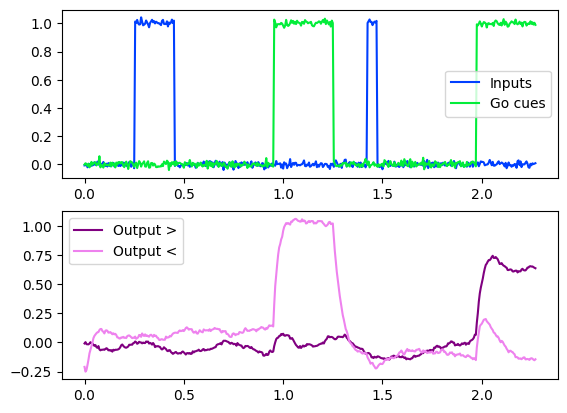

In [ ]:
time2 = np.arange(0, int(end2[0])) * step
plt.subplot(211)
plt.plot(time2, data2[0, :, :].numpy())
plt.legend(["Inputs", "Go cues"])
plt.subplot(212)
plt.plot(time2, scores[0, :, 0].detach().numpy(), color="purple")
plt.plot(time2, scores[0, :, 1].detach().numpy(), color="violet")
plt.legend(["Output >", "Output <"])
plt.show()

### Stability

In [ ]:
def alpha_eq(x, S, W_rec, W_in, u, b_rec, tau):
  x = x.reshape(-1, 1)
  return ((-x + S(W_rec @ x + W_in @ u + b_rec)) / tau).flatten()

def vanilla_eq(x, S, W_rec, W_in, u, b_rec, tau):
  x = x.reshape(-1, 1)
  return ((-x + W_rec @ S(x) + W_in @ u + b_rec) / tau).flatten()

def J_alpha(x, S_prime, W_rec, W_in, u, b_rec, tau):
  x = x.reshape(-1,1)
  S_term = np.diag(S_prime(W_rec @ x + W_in @ u + b_rec).flatten())
  return (-np.eye(W_rec.shape[0]) + S_term @ W_rec) / tau

def J_vanilla(x, S_prime, W_rec, W_in, u, b_rec, tau):
  x = x.reshape(-1,1)
  S_term = np.diag(S_prime(x).flatten())
  return (-np.eye(W_rec.shape[0]) + W_rec @ S_term) / tau

def stable_point_type(x, J):
  Jacobian = J(x, S_prime, W_rec, W_in, u, b_rec, tau)
  J_eigv, J_eigvec = np.linalg.eig(Jacobian)
  J_eigv_n = np.count_nonzero(np.real(J_eigv) < 0)
  J_eigv_p = np.count_nonzero(np.real(J_eigv) > 0)

  if J_eigv_p == 0:
    print("Atractor\n\n")
  elif J_eigv_n == 0:
    print("Repeler\n\n")
  else:
    print(f"Saddle, negative:{J_eigv_n}, positive:{J_eigv_p}\n\n")

  return J_eigv, J_eigvec

if model_name == "Vanilla_TICT_1.txt":
  eq = vanilla_eq
  J = J_vanilla
  W_rec = model.i2h.weight[:, n_inputs:].detach().numpy()
  W_in = model.i2h.weight[:, :n_inputs].detach().numpy()
  b_rec = model.i2h.bias.detach().numpy().reshape(-1, 1)
else:
  eq = alpha_eq
  J = J_alpha
  W_rec = model.W_rec.detach().numpy()
  W_in =  model.W_in.detach().numpy()
  b_rec = model.b.detach().numpy().reshape(-1, 1)

S = lambda x: np.where(x < 20, np.log(1 + np.exp(x)), x)
S_prime = lambda x: 1 / (1 + np.exp(-x))
u = np.zeros((n_inputs, 1))

x0 = np.zeros((hidden_size, 1))
root_dx = root(eq, x0, args=(S, W_rec, W_in, u, b_rec, tau), method='lm')
J_eigv, J_eigvec = stable_point_type(root_dx.x, J)
root_dx

Saddle, negative:254, positive:2




 message: The relative error between two consecutive iterates is at most 0.000000
 success: True
  status: 2
     fun: [-6.772e-14  1.531e-13 ...  1.188e-13 -1.988e-14]
       x: [ 1.927e-04  2.509e-02 ...  7.681e-05  4.520e-05]
   cov_x: [[ 6.254e-04  1.312e-05 ...  7.740e-08 -2.629e-08]
           [ 1.312e-05  1.516e-03 ...  5.256e-06 -6.983e-07]
           ...
           [ 7.740e-08  5.256e-06 ...  6.253e-04 -1.343e-08]
           [-2.629e-08 -6.983e-07 ... -1.343e-08  6.250e-04]]
  method: lm
    nfev: 5659
    fjac: [[-4.101e+01  0.000e+00 ...  0.000e+00  0.000e+00]
           [-1.049e+00 -4.029e+01 ...  0.000e+00  0.000e+00]
           ...
           [ 8.563e-02  5.617e-02 ...  6.349e-01 -2.024e-01]
           [ 1.056e-01  5.080e-02 ... -2.422e-01  2.554e-02]]
    ipvt: [161  97 ...  29  39]
     qtf: [-1.342e-10  3.809e-10 ... -2.239e-09 -4.629e-09]

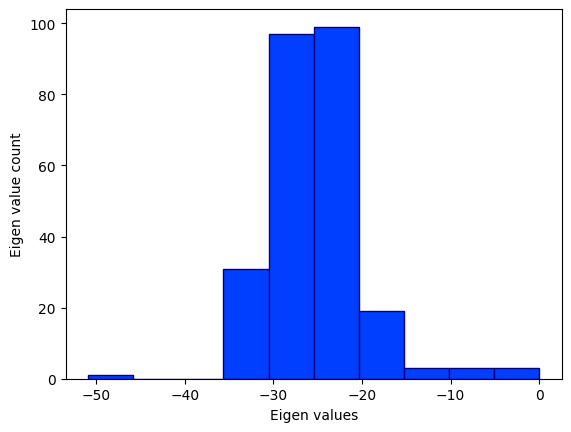

In [ ]:
def plot_eigenvalue_histogram(J_eigv):
  plt.hist(J_eigv.real, edgecolor="navy")
  plt.ylabel("Eigen value count")
  plt.xlabel("Eigen values")
  plt.show()

plot_eigenvalue_histogram(J_eigv)

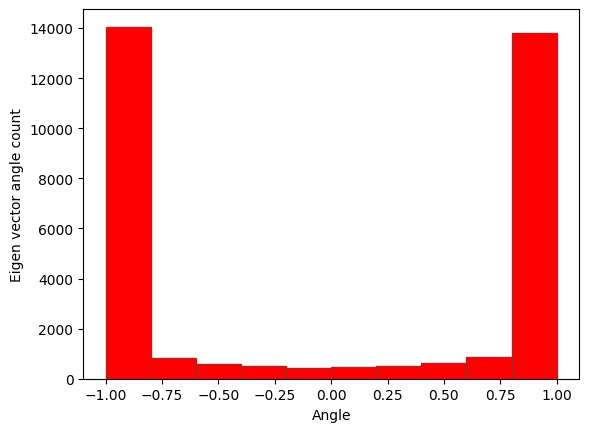

In [ ]:
def plot_eigenvector_histogram(J_eigvec):
  angles = np.array([])
  for i in range(J_eigvec.shape[1]):
    for j in range(i + 1, J_eigvec.shape[1]):
      angle = np.vdot(J_eigvec[:,i], J_eigvec[:,j])
      angle /= np.linalg.norm(angle)
      #angle = np.arccos(angle) * 180 / np.pi
      angles = np.append(angles, angle)

  plt.hist(angles.real, facecolor="red", edgecolor="firebrick")
  plt.ylabel("Eigen vector angle count")
  plt.xlabel("Angle")
  plt.show()

plot_eigenvector_histogram(J_eigvec)

### PCA

In [ ]:
batch_size = 400
inputs, labels, starts, ends, Ts, obj = get_random_trials()
T2s = Ts[1, :]
T3s = Ts[2, :]
data, targets = get_data(inputs, labels)

scores, hidden = trials_analysis(model, data, ends)

#Get the delay
len_delay = time2indx(t_max_delay)
hidden_delay = np.zeros((batch_size, len_delay, hidden_size))
for b in range(batch_size):
  hidden_delay = hidden[:, Ts[0, b] + Ts[1, b]:Ts[4, b], :] \
                  .detach().numpy()

#Get class avg
n_class = len(stim1s)
class_avg = np.zeros((n_class, len_delay, hidden_size))
for ti, t in enumerate(stim1s):
  class_t = np.where(Ts[1, :] == time2indx(t))[0]
  class_avg[ti, :, :] = np.mean(hidden_delay[class_t, :, :], axis = 0)

n_components = 5

PCA_data = class_avg.reshape(-1, 256)
pca = PCA(n_components = n_components)
pca.fit(PCA_data)
principal_components = pca.components_

print("Principal components shape:", principal_components.shape)

Principal components shape: (5, 256)


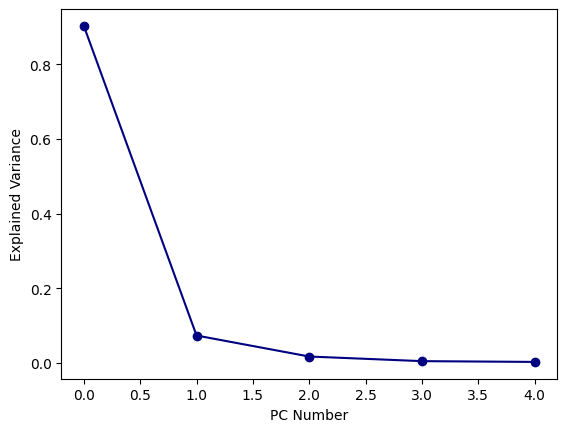

In [ ]:
exp_var = pca.explained_variance_ratio_

plt.plot(exp_var, marker = "o", color = "navy")
plt.ylabel("Explained Variance")
plt.xlabel("PC Number")
plt.show()

In [ ]:
import matplotlib.colors as mcolors

start_color = "#caf0f8" # Dark blue
end_color = "#03045e"    # Light blue
cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient",
 [start_color, end_color])
c_vec = [cmap(i / (n_class - 1)) for i in range(n_class)]

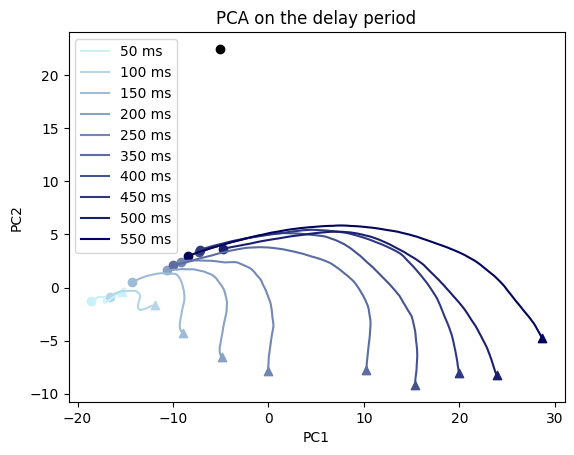

In [ ]:
projected_data = pca.transform(PCA_data)
projected_data = projected_data.reshape(n_class, len_delay, n_components)

for c in range(n_class):
  plt.plot(projected_data[c, :, 0], projected_data[c, :, 1], color = c_vec[c],
           label= str(int(stim1s[c]*1000)) + " ms")
  plt.scatter(projected_data[c, 0, 0], projected_data[c, 0, 1], marker="o",
              color = c_vec[c])
  plt.scatter(projected_data[c, -1, 0], projected_data[c, -1, 1], marker="^",
              color = c_vec[c])

stable_point = pca.transform(root_dx.x.reshape(1, -1)).flatten()
plt.scatter(stable_point[0], stable_point[1], color="black")
plt.title("PCA on the delay period")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

### Simulate more states

In [ ]:
def euler(x0, x_dot, parm, steps = 1000, dt=1e-3):
  x = np.copy(x0)
  xs = np.zeros((steps, *x0.shape))
  for step in range(steps):
    xs[step, :] = x
    x += dt*x_dot(x, *parm)

  return xs

n_seeds = 20
diff_vec = class_avg[-1, 0, :] - class_avg[0, 0, :]
seeds = class_avg[0, 0, :] + \
        np.linspace(0, 1, n_seeds).reshape(-1, 1) * diff_vec

n_steps = 1000
trajectories = np.zeros((n_steps, n_seeds, hidden_size))

for s in range(n_seeds):
  trajectories[:, s, :] = euler(seeds[s, :], eq,
                                (S, W_rec, W_in, u, b_rec, tau), steps = n_steps)

success
Saddle, negative:254, positive:2




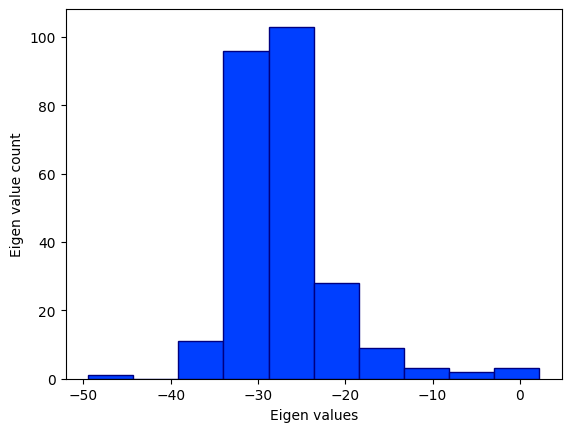

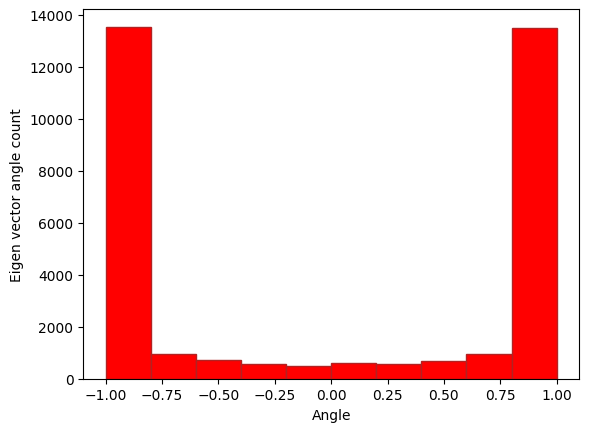

In [ ]:
# The search for the separatrix

s = 13 # trajectory near the separatrix
for t in range(n_steps):
  x0_s = trajectories[t, s, :].reshape(-1, 1)
  root_dx_s = root(alpha_eq, x0_s, args=(S, W_rec, W_in, u, b_rec, tau), method='lm')
  if not np.allclose(root_dx.x, root_dx_s.x, rtol=1e-1):
    print("success")
    J_eigv2, J_eigvec2 = stable_point_type(root_dx_s.x, J)
    break

plot_eigenvalue_histogram(J_eigv2)
plot_eigenvector_histogram(J_eigvec2)

In [ ]:
# End attractor

s = -1 # end trajectory
for t in np.arange(n_steps - 1, 0, -int(n_steps/20)):
  x0_s = trajectories[t, s, :].reshape(-1, 1)
  root_dx_e = root(alpha_eq, x0_s, args=(S, W_rec, W_in, u, b_rec, tau), method='lm')
  if not np.allclose(root_dx.x, root_dx_e.x, rtol=1e-1) and \
      not np.allclose(root_dx_s.x, root_dx_e.x, rtol=1e-1):
    print("success")
    _ = stable_point_type(root_dx_e.x, J)
    break


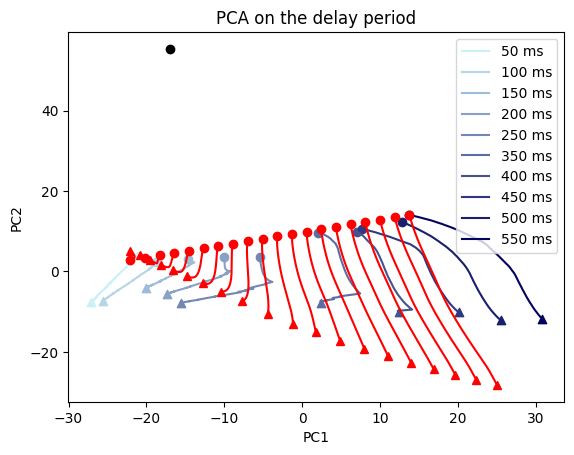

In [ ]:
for c in range(n_class):
  plt.plot(projected_data[c, :, 0], projected_data[c, :, 1], color = c_vec[c],
           label= str(int(stim1s[c]*1000)) + " ms")
  plt.scatter(projected_data[c, 0, 0], projected_data[c, 0, 1], marker="o",
              color = c_vec[c])
  plt.scatter(projected_data[c, -1, 0], projected_data[c, -1, 1], marker="^",
              color = c_vec[c])

for s in np.arange(0, n_seeds):
  projected_tra = pca.transform(trajectories[:, s, :])
  plt.plot(projected_tra[:, 0], projected_tra[:, 1], color = "red")
  plt.plot(projected_tra[0, 0], projected_tra[0, 1], marker="o", color = "red")
  plt.plot(projected_tra[-1, 0], projected_tra[-1, 1], marker="^", color = "red")

stable_point = pca.transform(root_dx.x.reshape(1, -1)).flatten()
plt.scatter(stable_point[0], stable_point[1], color="black")

#stable_point = pca.transform(root_dx_s.x.reshape(1, -1)).flatten()
#plt.scatter(stable_point[0], stable_point[1], color="black", marker="*")

"""
stable_point = pca.transform(root_dx_e.x.reshape(1, -1)).flatten()
plt.scatter(stable_point[0], stable_point[1], color="black", marker="*")
"""
#plt.ylim([-20,20])
#plt.xlim([-40,0])

plt.title("PCA on the delay period")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [ ]:
# When the stimulus is on

x0 = np.copy(root_dx.x)
u[0] = 1
root_dx_1 = root(alpha_eq, x0, args=(S, W_rec, W_in, u, b_rec, tau), method='lm')
stable_point_type(root_dx_1.x)
root_dx_1

Saddle




 message: Both actual and predicted relative reductions in the sum of squares
            are at most 0.000000
 success: True
  status: 1
     fun: [-8.078e-02 -8.612e-02 ...  1.342e-02 -9.530e-02]
       x: [ 1.514e-02  1.166e-02 ...  1.805e-02  1.658e-02]
   cov_x: [[ 4.154e-03 -1.976e-02 ...  2.031e-02  4.157e-02]
           [-1.976e-02  1.118e-01 ... -1.142e-01 -2.339e-01]
           ...
           [ 2.031e-02 -1.142e-01 ...  1.181e-01  2.404e-01]
           [ 4.157e-02 -2.339e-01 ...  2.404e-01  4.927e-01]]
  method: lm
    nfev: 50656
    fjac: [[ 3.997e+01  1.861e-03 ...  1.078e-03  1.172e-03]
           [ 9.509e-03  3.996e+01 ...  1.243e-03  9.325e-04]
           ...
           [ 5.510e-03  6.351e-03 ...  1.642e-01  2.606e-03]
           [ 5.986e-03  4.763e-03 ...  2.895e-03  3.975e-05]]
    ipvt: [  3  96 ...  39 180]
     qtf: [ 5.183e-03  3.963e-04 ... -1.100e-01 -2.573e+01]

In [ ]:
x0 = trajectories[0, -1, :].reshape(-1, 1)
root_dx_2 = root(alpha_eq, x0, args=(S, W_rec, W_in, u, b_rec, tau), method='lm')
if not np.allclose(root_dx_2.x, root_dx_1.x, rtol=1e-1):
  stable_point_type(root_dx_2.x)
  root_dx_2

<ipython-input-26-c799b8a03ab7>:29: RuntimeWarning: overflow encountered in exp
  S = lambda x: np.where(x < 20, np.log(1 + np.exp(x)), x)


Saddle




### Different alpha

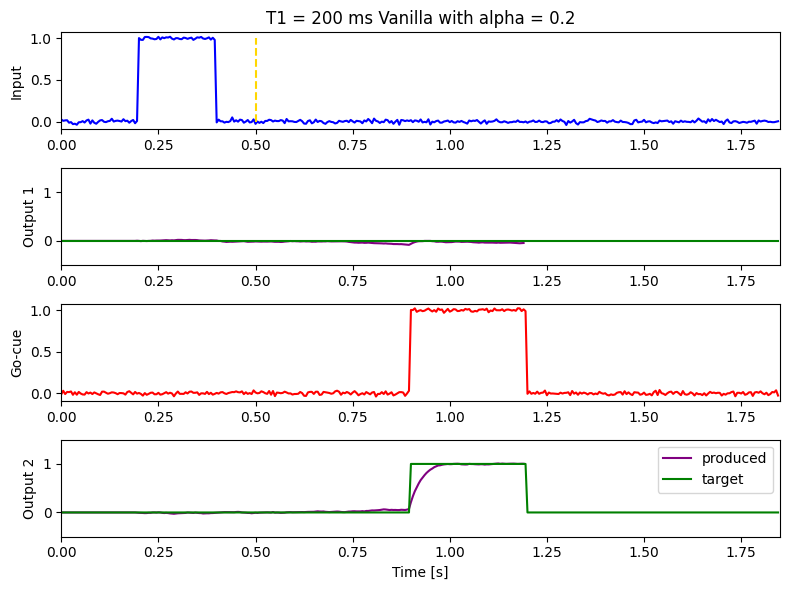

In [ ]:
inputs, labels, starts, ends, Ts, obj = get_random_trials()
T2s = Ts[1, :]
T3s = Ts[2, :]
data, targets = get_data(inputs, labels)

with torch.no_grad():
  scores = torch.zeros(targets.shape)
  hidden = torch.zeros(batch_size, len(tv), hidden_size)
  for b in range(batch_size):
    scores1, hidden1 = model.foward_euler(data, ends, b, alpha)
    hidden[b, :, :] = hidden1
    scores1[0, :int(starts[0, b] - 1), :] *= 0
    scores[b, :int(ends[0, b]), :] = scores1

n = 1
title = "T1 = " + str(int(T2s[n] * step * 1e3)) + " ms" + \
        " Vanilla with alpha = 0.2"
plot_trial(n, title)

### Weights

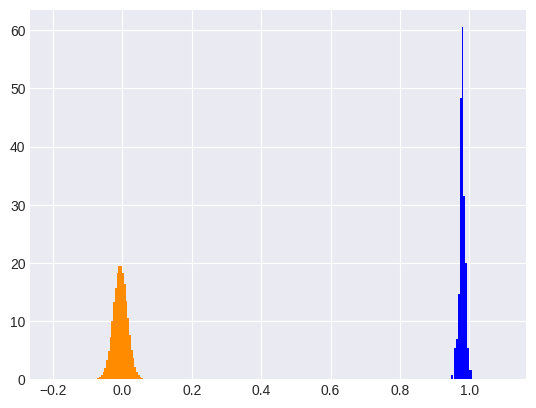

In [ ]:
pesos = model.i2h.weight[:,2:].detach().numpy()
bin = np.linspace(-0.2,1.1,256)
plt.hist(pesos.flatten(),bins=bin,color="darkorange",density=True)
plt.hist(np.diag(pesos),bins=bin,color="blue",density=True)
plt.show()

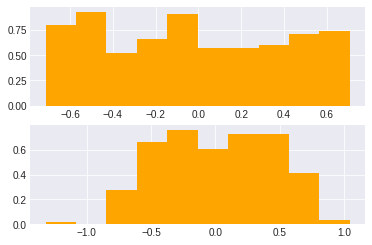

In [ ]:
pesos = model.i2h.weight[:,0:2].detach().numpy()
plt.subplot(211)
plt.hist(pesos[:,0].flatten(),color="orange",density=True)
plt.subplot(212)
plt.hist(pesos[:,1].flatten(),color="orange",density=True)
plt.show()

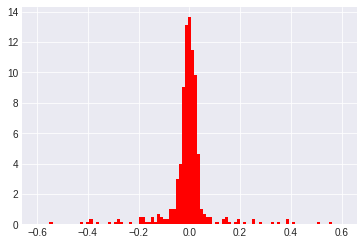

In [ ]:
pesos = model.h2o.weight.detach().numpy()
bin = np.linspace(-0.6,0.6,100)
plt.hist(pesos.flatten(),bins=bin,color="red",density=True)
plt.show()

### Activity

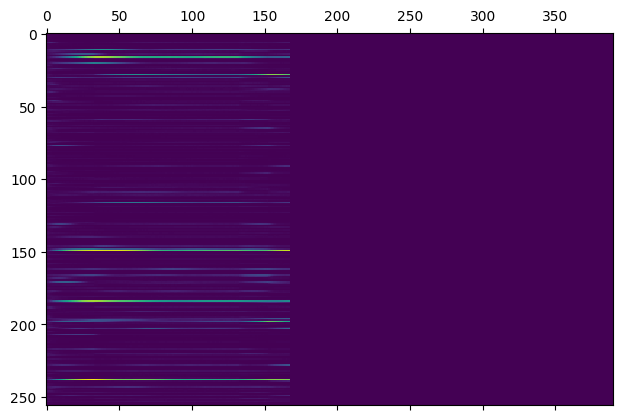

In [ ]:
plt.style.use('default')
oculton = hidden.detach().numpy()
plt.matshow(oculton[5,:,:].transpose())
plt.show()

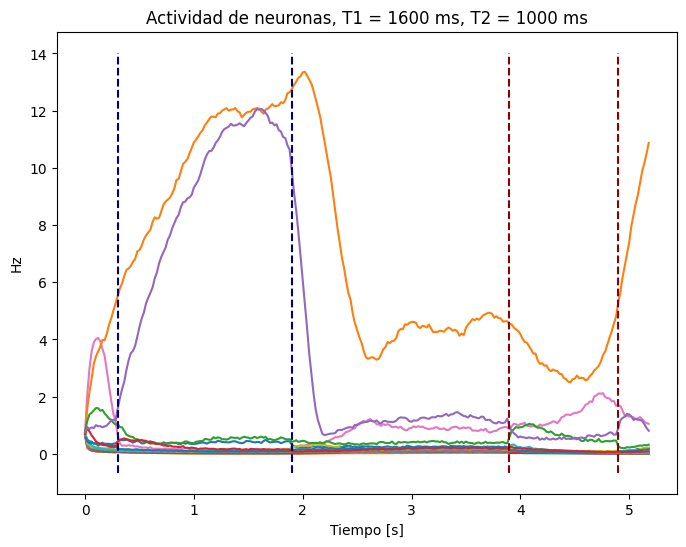

In [ ]:
n = 2
plt.figure(figsize=(8,6))

for neu in range(15):
  plt.plot(tv[:int(ends[0,n])],oculton[n,:int(ends[0,n]),neu])

axes = plt.gca()
yi, ys = axes.get_ylim()
plt.vlines([tv[int(starts[0,n])],tv[int(starts[0,n]+T2s[0,n])],tv[int(starts[0,n]+T2s[0,n]+T3s[0,n])],tv[int(starts[0,n]+T2s[0,n]+T3s[0,n]+T2s[1,n])]],yi,ys, color=["navy","navy","darkred","darkred"],linestyles="dashed")
plt.title("Actividad de neuronas, T1 = "+str(int(T2s[0,n]*20))+" ms, T2 = "+str(int(T2s[1,n]*20))+" ms")
plt.ylabel("Hz")
plt.xlabel("Tiempo [s]")
plt.savefig("ICT_an.svg")
plt.show()